# Integrated gradients for text classification on imdb dataset

A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb). Integrated gradients was originally proposed in [here](https://arxiv.org/abs/1703.01365).

In [3]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import os
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Convolution1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
%matplotlib inline
tf.test.is_gpu_available()

True

## Load data

In [4]:
NUM_WORDS=1000 # only use top 1000 words
INDEX_FROM=3   # word index offset

word_to_id = tf.keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}

In [5]:
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
test_labels = y_test.copy()
train_labels = y_train.copy()
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [8]:
print(' '.join(id_to_word[id] for id in x_train[10] ))

corner and this helps to ensure that maléfique actually does manage to be quite frightening the film is memorable for a lot of reasons outside the central plot the characters are all very interesting in their own way and the fact that the book itself almost takes on its own character is very well done anyone worried that the film won't deliver by the end won't be disappointed either as the ending both makes sense and manages to be quite horrifying overall maléfique is a truly great horror film and one of the best of the decade highly recommended viewing


## Train Model

In [9]:
load_model = False

In [10]:
filepath = './model_imdb/'  # change to directory where model is downloaded
if load_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    print('Build model...')
    
    inputs = Input(shape=(100,), dtype='int32')
    embedded_sequences = Embedding(max_features, 128)(inputs)
    l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(128, activation='relu')(l_flat)
    outputs = Dense(2, activation='softmax')(l_dense)
        
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    print('Train...')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test))
        
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model.h5'))

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 20s 816us/sample - loss: 0.4433 - acc: 0.7641 - val_loss: 0.3711 - val_acc: 0.8379
Epoch 2/10
25000/25000 [==============================] - 18s 707us/sample - loss: 0.2031 - acc: 0.9234 - val_loss: 0.4136 - val_acc: 0.8381
Epoch 3/10
25000/25000 [==============================] - 18s 701us/sample - loss: 0.0657 - acc: 0.9766 - val_loss: 0.4656 - val_acc: 0.8358
Epoch 4/10
25000/25000 [==============================] - 17s 695us/sample - loss: 0.0182 - acc: 0.9942 - val_loss: 0.9109 - val_acc: 0.8303
Epoch 5/10
25000/25000 [==============================] - 17s 693us/sample - loss: 0.0159 - acc: 0.9943 - val_loss: 0.9687 - val_acc: 0.8343
Epoch 6/10
25000/25000 [==============================] - 17s 691us/sample - loss: 0.0160 - acc: 0.9940 - val_loss: 0.8814 - val_acc: 0.8328
Epoch 7/10
25000/25000 [==============================] - 18s 703us/sample - los

## Calculate integrated Gradients

In [14]:
n_steps = 50
method = "gausslegendre"
return_convergence_delta = True
return_predictions = False
ig  = IntegratedGradients(model, layer=model.layers[1],
                          n_steps=n_steps, 
                          method=method,
                          return_convergence_delta=return_convergence_delta, 
                          return_predictions=return_predictions)

In [15]:
nb_samples = 10
x_test_red = x_test[:nb_samples]
test_labels_red = test_labels[:nb_samples]

In [16]:
explanation = ig.explain(x_test_red, 
                         baselines=None, 
                         target=test_labels_red, 
                         internal_batch_size=100)

In [17]:
attrs = explanation['data']['attributions']

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


## Visualize attributions

In [46]:
i = 1
sample_sentence = ' '.join(id_to_word[ids] for ids in x_test_red[i] )
print(sample_sentence)

a powerful study of loneliness sexual repression and desperation be patient <UNK> up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with unconventional fascinating subject matter this film is disturbing but it's sincere and it's sure to elicit a strong emotional response from the viewer if you want to see an unusual film some might even say bizarre this is worth the time br br unfortunately it's very difficult to find in video stores you may have to buy it off the internet


In [48]:
attrs_0 = attrs[i].sum(axis=1)

In [49]:
words = sample_sentence.split(' ')
attrs_0 = attrs_0.tolist()
while '<PAD>' in words:
    words.pop(0)
    attrs_0.pop(0)

In [50]:
df = pd.DataFrame()
df['words'] = words
df['attributions'] = attrs_0
df.set_index('words', inplace=True)
df = df.iloc[::-1]

1


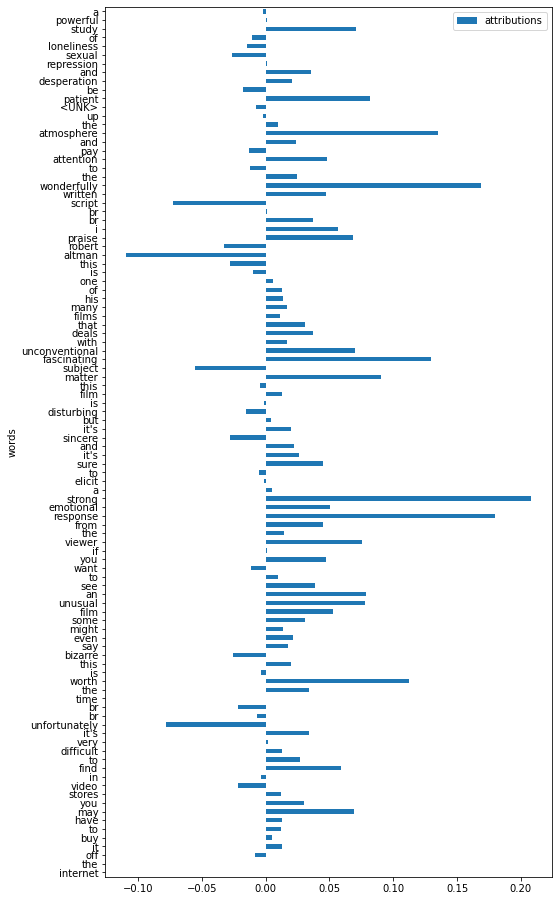

In [53]:
print(test_labels[1])
df.plot(kind='barh', figsize=(8, 16))